# SNN de los ganglios basales

Red de impulsos de los ganglios basales usando la implementación de los modelos de Terman y Rubin para neuronas del STN y GPe. El resto de parámetros de la simulación se extraen de Shouno et al.


### Referencias

Terman, D., Rubin, J. E., Yew, A. C., & Wilson, C. J. (2002). Activity patterns in a model for the subthalamopallidal network of the basal ganglia. Journal of Neuroscience, 22(7), 2963-2976.

Shouno, O., Tachibana, Y., Nambu, A., & Doya, K. (2017). Computational model of recurrent subthalamo-pallidal circuit for generation of parkinsonian oscillations. Frontiers in Neuroanatomy, 11, 21.

In [1]:
# nest 
import nest
import nest.voltage_trace
from pynestml.frontend.pynestml_frontend import generate_nest_target


# gráficas
import matplotlib.pyplot as plt

# cálculo
from scipy import stats as st
from scipy import signal
from random import randint
import numpy as np

NEST_SIMULATOR_INSTALL_LOCATION = nest.ll_api.sli_func('statusdict/prefix ::')

nest.set_verbosity('M_WARNING')
nest.ResetKernel()


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: UNKNOWN
 Built: Apr 14 2022 16:45:38

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



## Modelos TERUB

#### Modelo para el STN: `terub_stn`

In [2]:
generate_nest_target(input_path='models/terub_stn.nestml',
                     target_path='/tmp/terub_stn',
                     logging_level='ERROR',
                     module_name='terub_stn_module',
                     codegen_opts={'nest_path': NEST_SIMULATOR_INSTALL_LOCATION})



-- The CXX compiler identification is GNU 9.4.0
-- Check for working CXX compiler: /usr/bin/c++
-- Check for working CXX compiler: /usr/bin/c++ -- works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Detecting CXX compile features
-- Detecting CXX compile features - done

-------------------------------------------------------
terub_stn_module Configuration Summary
-------------------------------------------------------

C++ compiler         : /usr/bin/c++
Build static libs    : OFF
C++ compiler flags   : 
NEST compiler flags  :  -O2 -std=c++11 -Wall -fopenmp -pthread -fdiagnostics-color=auto
NEST include dirs    :  -I/opt/nest/include/nest -I/usr/include -I/usr/include -I/usr/include -I/opt/music-install/include -I/usr/lib/x86_64-linux-gnu/openmpi/include/openmpi -I/usr/lib/x86_64-linux-gnu/openmpi/include -I/usr/include
NEST libraries flags : -L/opt/nest/lib/nest -lnestutil -lnest -lsli -lnestkernel -fopenmp /usr/lib/x86_64-linux-gnu/libltdl.so /usr

In [3]:
nest.Install('terub_stn_module')

#### Modelo para el GPe: `terub_gpe`

In [4]:
generate_nest_target(input_path='models/terub_gpe.nestml',
                    target_path='/tmp/nestml-component',
                     logging_level='ERROR',
                     module_name='terub_gpe_module',
                     codegen_opts={'nest_path': NEST_SIMULATOR_INSTALL_LOCATION})

-- The CXX compiler identification is GNU 9.4.0
-- Check for working CXX compiler: /usr/bin/c++
-- Check for working CXX compiler: /usr/bin/c++ -- works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Detecting CXX compile features
-- Detecting CXX compile features - done

-------------------------------------------------------
terub_gpe_module Configuration Summary
-------------------------------------------------------

C++ compiler         : /usr/bin/c++
Build static libs    : OFF
C++ compiler flags   : 
NEST compiler flags  :  -O2 -std=c++11 -Wall -fopenmp -pthread -fdiagnostics-color=auto
NEST include dirs    :  -I/opt/nest/include/nest -I/usr/include -I/usr/include -I/usr/include -I/opt/music-install/include -I/usr/lib/x86_64-linux-gnu/openmpi/include/openmpi -I/usr/lib/x86_64-linux-gnu/openmpi/include -I/usr/include
NEST libraries flags : -L/opt/nest/lib/nest -lnestutil -lnest -lsli -lnestkernel -fopenmp /usr/lib/x86_64-linux-gnu/libltdl.so /usr/l

In [5]:
nest.Install('terub_gpe_module')

## Parámetros simulación

In [6]:
# tiempo de la simulación
simtime = 2000.0

## Parámetros STN

In [7]:
# numero de neuronas stn
n_stn = 64

# probabilidad de conexión hacia el gpe (6/64)
n_conn_stn_to_gpe = 6

# pesos sinápticos stn
weight_stn = 1.35

# axonal conduction delay (presente en stn->gpe y gpe->stn)
axonal_cond_delay = 5

## Parámetros GPe


In [8]:
# numero de neuronas gpe
n_gpe = 192

# probabilidad de conexion hacia el gpe (12/192)
n_conn_gpe_to_stn = 12

# pesos sinápticos gpe
weight_gpe = 7.3

## Parámetros GPe-Int (Poisson)

In [9]:
# numero neuronas
n_gpe_int = 192

# tasa de disparo gpe-int (Hz)
rate_gpe_int = 30.0

# pesos sinápticos poisson
weight_gpe_int = 0.0

## Parámetros Cortex (Poisson)

In [10]:
# numero de neuronas cortex
n_ctx = 64

# tasa de disparo cortex (Hz)
rate_ctx = 30.0  

# pesos sinápticos cortex
weight_ctx = 1.0

## Poblaciones

In [11]:
# núcleos
stn = nest.Create("terub_stn", n_stn)
gpe = nest.Create("terub_gpe", n_gpe)

# gpe internal noisy conductance
gpe_int = nest.Create("poisson_generator", n_gpe_int, params={'rate': rate_gpe_int})

# cortex
ctx = nest.Create("poisson_generator", n_ctx, params={'rate': rate_ctx})

# recorders stn y gpe
spike_recorder_stn = nest.Create("spike_recorder")
spike_recorder_gpe = nest.Create("spike_recorder")
spike_recorder_gpe_int = nest.Create("spike_recorder")
spike_recorder_ctx = nest.Create("spike_recorder")

### Conexiones

In [12]:
# stn --> gpe
nest.Connect(
    stn, gpe, {'rule': 'fixed_total_number', 'N': n_conn_stn_to_gpe},
    syn_spec={'synapse_model': 'quantal_stp_synapse', 'weight': weight_stn, 'delay': axonal_cond_delay}
)

# gpe --> stn
nest.Connect(
    gpe, stn, {'rule': 'fixed_total_number', 'N': n_conn_gpe_to_stn},
    syn_spec={'synapse_model': 'quantal_stp_synapse', 'weight': weight_gpe, 'delay': axonal_cond_delay}
)

# gpe_int --> gpe
nest.Connect(
    gpe_int, gpe, {'rule': 'one_to_one'},
    syn_spec={'weight': weight_gpe_int}
)

# cortex --> stn
nest.Connect(
    ctx, stn, {'rule': 'pairwise_bernoulli', 'p': 0.03},
    syn_spec={'weight': weight_ctx}
)

# spike recorders
nest.Connect(stn, spike_recorder_stn)
nest.Connect(gpe, spike_recorder_gpe)
nest.Connect(gpe_int, spike_recorder_gpe_int)
nest.Connect(ctx, spike_recorder_ctx)

In [13]:
# multímetros al stn
multimeter_stn = []

for i in range(64):
    multimeter = nest.Create("multimeter")
    multimeter.interval = 0.1
    multimeter.set(record_from=['V_m'])
    nest.Connect(multimeter, stn[i])
    multimeter_stn.append(multimeter)
    
    
# multímetro al gpe
multimeter_gpe = []

for i in range(64):
    multimeter = nest.Create("multimeter")
    multimeter.interval = 0.1
    multimeter.set(record_from=['V_m'])
    nest.Connect(multimeter, gpe[i])
    multimeter_gpe.append(multimeter)

## Simulación

In [14]:
nest.Simulate(simtime)

### Voltajes de neurona

#### STN

Text(0, 0.5, 'voltaje (mV)')

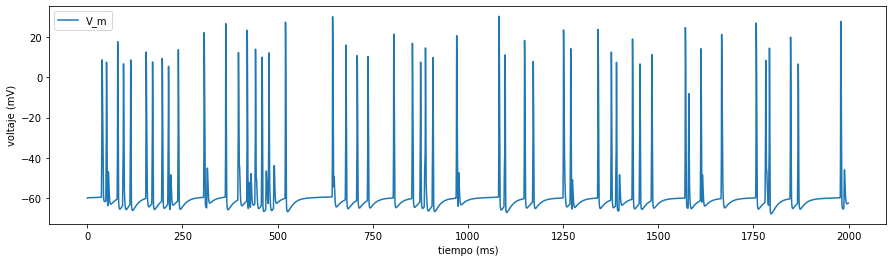

In [15]:
dmm = multimeter_stn[0].get()

plt.rcParams['figure.figsize'] = (15,4)

ts = dmm["events"]["times"]
Vms = dmm["events"]["V_m"]

ax0 = plt.subplot()
ax0.plot(ts, Vms, label='V_m', color='C0')
ax0.legend(loc='upper left')

ax0.set_xlabel('tiempo (ms)')
ax0.set_ylabel('voltaje (mV)')

#plt.xlim((85,180))

#### GPe

Text(0, 0.5, 'voltaje (mV)')

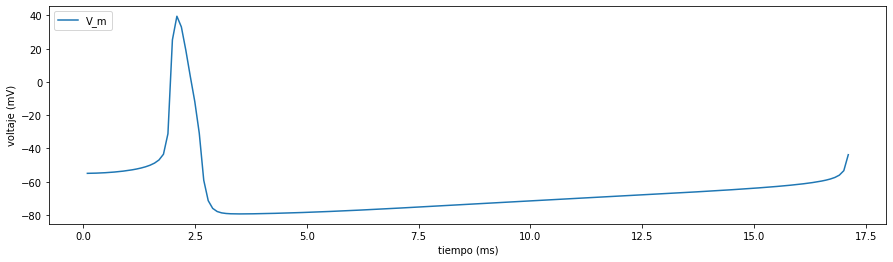

In [16]:
dmm = multimeter_gpe[0].get()

plt.rcParams['figure.figsize'] = (15,4)

ts = dmm["events"]["times"]
Vms = dmm["events"]["V_m"]

ax0 = plt.subplot()
ax0.plot(ts, Vms, label='V_m', color='C0')
ax0.legend(loc='upper left')

ax0.set_xlabel('tiempo (ms)')
ax0.set_ylabel('voltaje (mV)')

#plt.xlim((250,260))

### Registro de disparos por población

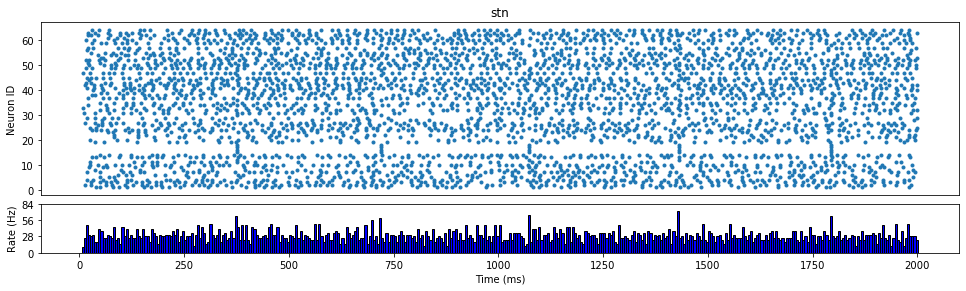

In [29]:
nest.raster_plot.from_device(spike_recorder_stn, hist=True)
plt.title('stn')
plt.show()

No events recorded!


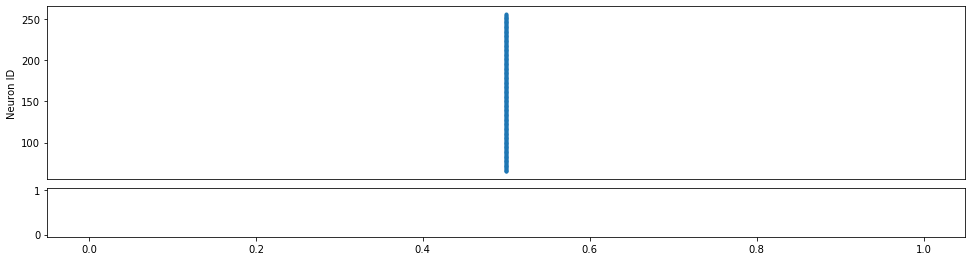

In [18]:
try:
    nest.raster_plot.from_device(spike_recorder_gpe, hist=True)
    plt.title('gpe')
    plt.show()
except:
    print('No events recorded!')

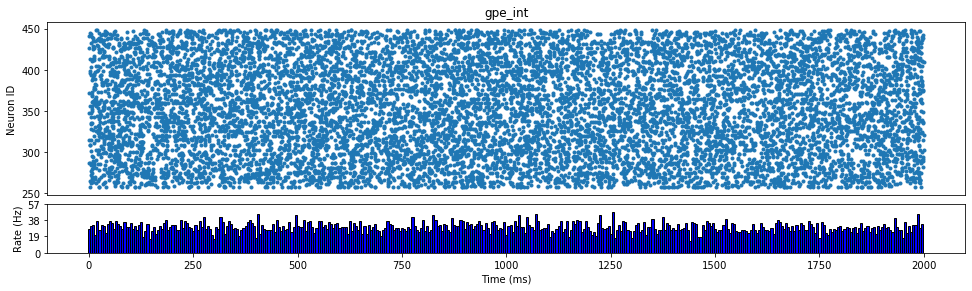

In [19]:
nest.raster_plot.from_device(spike_recorder_gpe_int, hist=True)
plt.title('gpe_int')
plt.show()

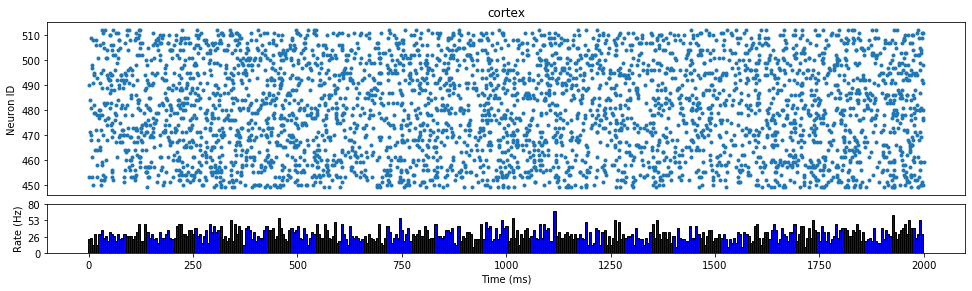

In [20]:
nest.raster_plot.from_device(spike_recorder_ctx, hist=True)
plt.title('cortex')
plt.show()

### Conexiones en la red

In [21]:
conn = nest.GetConnections()
nest.PrintNodes()

  1 ..  64 terub_stn
 65 .. 256 terub_gpe
257 .. 512 poisson_generator
513 .. 516 spike_recorder
517 .. 644 multimeter


# Métricas de análisis

## Power spectral density

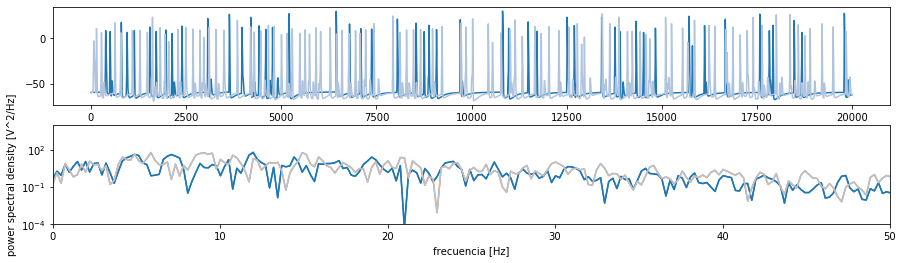

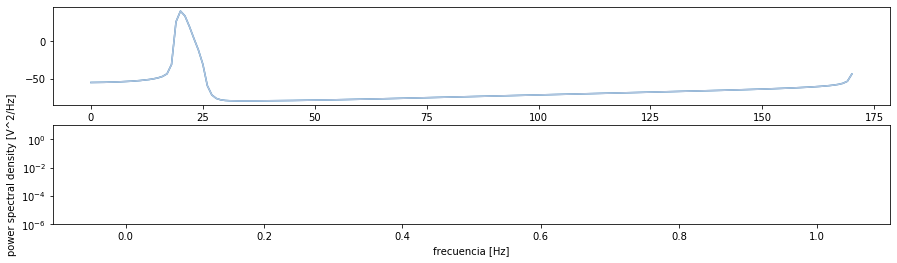

In [22]:
stn_data, gpe_data = ([] for i in range(2))

for i in range(64):
    stn_data.append(multimeter_stn[i].events['V_m'])
    gpe_data.append(multimeter_gpe[i].events['V_m'])
    
# stn
plt.subplot(211)

plt.plot(stn_data[0])
plt.plot(stn_data[1], color='lightsteelblue')

conf_level_data_stn = dict()

plt.subplot(212)

for i in range(2):
    f, Pxx_den = signal.periodogram(x=stn_data[i], fs=1000, window=('hamming'), nfft=4096)
    plt.semilogy(f, Pxx_den)
    data_log = plt.semilogy(f, Pxx_den, color=('C0' if i==0 else 'lightsteelblue'))
    conf_level_data_stn[i] = dict()
    conf_level_data_stn[i]['y'] = data_log[0].get_ydata()
    conf_level_data_stn[i]['x'] = data_log[0].get_xdata()

plt.xlabel('frecuencia [Hz]')
plt.ylabel('power spectral density [V^2/Hz]')
    
plt.ylim((10e-5,10e3))
plt.xlim((0,50))
plt.show()

# gpe
plt.subplot(211)

plt.plot(gpe_data[0], color='C0')
plt.plot(gpe_data[1], color='lightsteelblue')

conf_level_data_gpe = dict()

plt.subplot(212)
for i in range(2):
    f, Pxx_den = signal.periodogram(x=gpe_data[i], fs=1000, window=('hamming'), nfft=4096)
    data_log = plt.semilogy(f, Pxx_den, color=('C0' if i==0 else 'lightsteelblue'))
    conf_level_data_gpe[i] = dict()
    conf_level_data_gpe[i]['y'] = data_log[0].get_ydata()
    conf_level_data_gpe[i]['x'] = data_log[0].get_xdata()

plt.xlabel('frecuencia [Hz]')
plt.ylabel('power spectral density [V^2/Hz]')
    
plt.ylim((10e-7,10))
#plt.xlim((0, 50)) 
plt.show()

### Intervalos de confianza STN

In [23]:
# número de puntos eje X
num_datos = len(conf_level_data_stn[0]['x'])

# mínimo y máximo para los intervalos de confianza (se calculan entre 270 y 300 Hz)
for i in range(num_datos):
    if conf_level_data_stn[0]['x'][i] >=270:
        indice_min = i
        break
        
for i in range(num_datos):
    if conf_level_data_stn[0]['x'][i] >= 300:
        indice_max = i + 1
        break
        
# recortar datos acorde a ese intervalo
for i in range(2):
    conf_level_data_stn[i]['x'] = conf_level_data_stn[i]['x'][indice_min:indice_max]
    conf_level_data_stn[i]['y'] = conf_level_data_stn[i]['y'][indice_min:indice_max]

(-2.2033241304267543e-05, 5.6506439919219994e-05)
(-6.70936563265278e-05, 0.00020976538352624087)


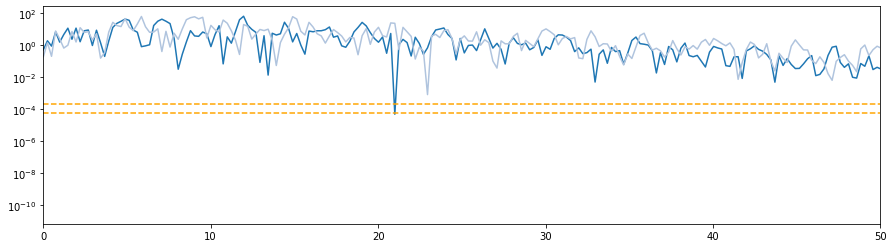

In [24]:
# intervalos de confianza al 99%

conf_interval_stn = []

for i in range(2):
    conf_interval_stn.append(st.norm.interval(alpha=0.99, loc=st.tmean(conf_level_data_stn[i]['y']), scale=st.tstd(conf_level_data_stn[i]['y'])))
    
for i in range(2):
    f, Pxx_den = signal.periodogram(x=stn_data[i], fs=1000, window=('hamming'), nfft=4096)
    data_log = plt.semilogy(f, Pxx_den, color=('C0' if i==0 else 'lightsteelblue'))
    plt.axhline(y=conf_interval_stn[i][0], color='wheat', linestyle='--')
    plt.axhline(y=conf_interval_stn[i][1], color='orange', linestyle='--')
    
plt.xlim(0,50)

print(conf_interval_stn[0])
print(conf_interval_stn[1])   

### Intervalos de confianza GPe

In [25]:
# número de puntos eje X
num_datos = len(conf_level_data_gpe[0]['x'])

# mínimo y máximo para los intervalos de confianza (se calculan entre 270 y 300 Hz)
for i in range(num_datos):
    if conf_level_data_gpe[0]['x'][i] >= 270:
        indice_min = i
        break
        
for i in range(num_datos):
    if conf_level_data_gpe[0]['x'][i] >= 300:
        indice_max = i + 1
        break
        
# recortar datos acorde a ese intervalo
for i in range(2):
    conf_level_data_gpe[i]['x'] = conf_level_data_gpe[i]['x'][indice_min:indice_max]
    conf_level_data_gpe[i]['y'] = conf_level_data_gpe[i]['y'][indice_min:indice_max]

(nan, nan)
(nan, nan)


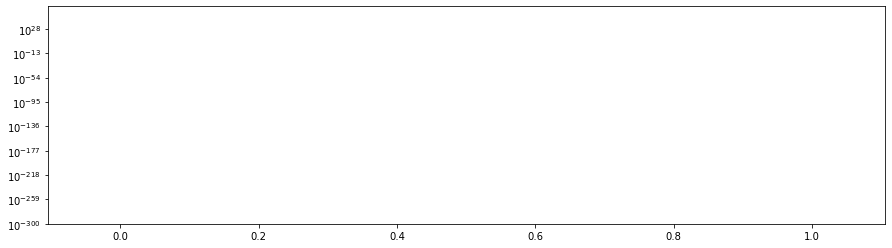

In [26]:
# intervalos de confianza al 99%

conf_interval = []

for i in range(2):
    conf_interval.append(st.norm.interval(alpha=0.99, loc=st.tmean(conf_level_data_gpe[i]['y']), scale=st.tstd(conf_level_data_gpe[i]['y'])))
    
for i in range(2):
    f, Pxx_den = signal.periodogram(x=gpe_data[i], fs=1000, window=('hamming'), nfft=4096)
    data_log = plt.semilogy(f, Pxx_den, color=('C0' if i==0 else 'lightsteelblue'))
    plt.axhline(y=conf_interval[i][0], color='wheat', linestyle='--')
    plt.axhline(y=conf_interval[i][1], color='orange', linestyle='--')
    
#plt.xlim(0,40)

print(conf_interval[0])
print(conf_interval[1])    

## Cross spectral analysis

/usr/local/lib/python3.8/dist-packages/numpy/ma/core.py:6852: RuntimeWarning:overflow encountered in power


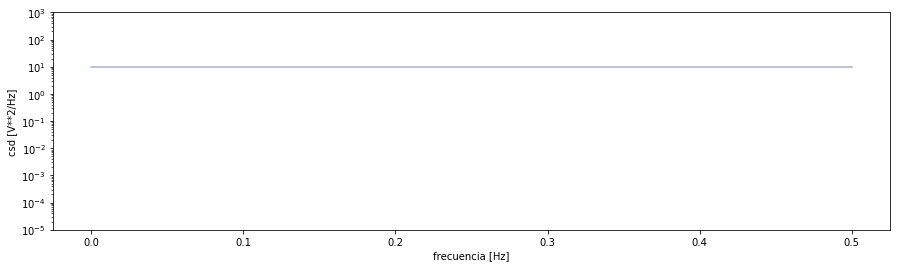

In [27]:
signals = []

#  csd de cada par de neuronas stn-gpe
for i in range(64):
    f, Pxy = signal.csd(x=stn_data[i], y=gpe_data[i], window='hann')
    line = plt.semilogy(f, np.abs(Pxy), color=('wheat' if (i%2)==0 else 'wheat'))
    signals.append(line[0].get_ydata())

# media de los csd anteriores  
# ---------------------------

fil = len(signals)
col = len(signals[0])
    
added_signals = [0] * col
    
for i in range(col):
    for j in range(fil):
        added_signals[i] = added_signals[i] + signals[j][i]

for i in range(col):
    added_signals[i] = added_signals[i] / fil 
    
# plotear la media         
plt.plot(f, added_signals, color='C0')
    
    
# sd de los csd anteriores
# ------------------------

signals_as_columns = np.array([np.array(signal) for signal in signals])
signals_as_columns = np.rot90(signals_as_columns, k=1, axes=(0, 1))
signals_as_columns = np.flip(signals_as_columns, 0)

signals_stds = []

for i in range(col):
    signals_stds.append( st.tstd(signals_as_columns[i]) )

# calcular límites std sobre la media
limite_stds_sup = []
limite_stds_inf = []

for i in range(col):
    if (added_signals[i] + signals_stds[i]) > 0:
        limite_stds_sup.append(added_signals[i] + signals_stds[i])
    else:
        limite_stds_sup.append(10)
    
    if (added_signals[i] - signals_stds[i]) > 0:
        limite_stds_inf.append(added_signals[i] - signals_stds[i])
    else:
        limite_stds_inf.append(10)

# plotear límite de la std 
linea_sup = plt.plot(f, limite_stds_sup, color='lightsteelblue')
linea_inf = plt.plot(f, limite_stds_inf, color='lightsteelblue')


#plt.fill_between(linea_inf, linea_sup, color='grey', alpha='0.5')


plt.xlabel('frecuencia [Hz]')
plt.ylabel('csd [V**2/Hz]')

plt.ylim(10e-6,10e2)

plt.show()

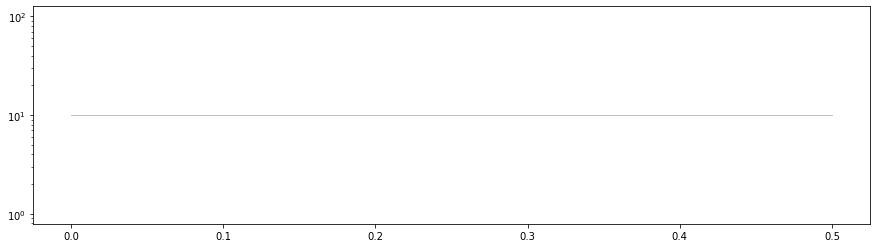

In [28]:
plt.semilogy(f, added_signals, color='C0')
plt.fill_between(x=f, y1=limite_stds_sup, y2=limite_stds_inf, color='lightsteelblue')